In [1]:
# Import libraries
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
t.manual_seed(42)

print("PyTorch version:", t.__version__)
print("CUDA available:", t.cuda.is_available())

PyTorch version: 2.6.0
CUDA available: False


In [2]:
# Generate synthetic time series data for testing
def create_test_data(n_series=5, n_timesteps=200, freq='D'):
    """Create synthetic time series data"""
    
    # Generate dates
    dates = pd.date_range('2020-01-01', periods=n_timesteps, freq=freq)
    
    data = []
    for i in range(n_series):
        # Create synthetic time series with trend, seasonality, and noise
        t_vals = np.arange(n_timesteps)
        
        # Trend component
        trend = 0.1 * t_vals + np.random.normal(0, 0.1, n_timesteps)
        
        # Seasonal component (weekly for daily data)
        if freq == 'D':
            seasonal = 2 * np.sin(2 * np.pi * t_vals / 7) + np.sin(2 * np.pi * t_vals / 30.5)
        else:
            seasonal = 2 * np.sin(2 * np.pi * t_vals / 12)
        
        # Noise
        noise = np.random.normal(0, 0.5, n_timesteps)
        
        # Combine components
        y = 10 + trend + seasonal + noise
        
        # Create dataframe for this series
        series_df = pd.DataFrame({
            'unique_id': f'ts_{i}',
            'ds': dates,
            'y': y
        })
        
        data.append(series_df)
    
    # Combine all series
    Y_df = pd.concat(data, ignore_index=True)
    
    # Create some exogenous variables
    X_df = Y_df.copy()
    X_df['trend'] = X_df.groupby('unique_id').cumcount()
    X_df['month'] = X_df['ds'].dt.month
    X_df['day_of_week'] = X_df['ds'].dt.dayofweek
    X_df = X_df[['unique_id', 'ds', 'trend', 'month', 'day_of_week']]
    
    # Create static variables
    S_df = pd.DataFrame({
        'unique_id': [f'ts_{i}' for i in range(n_series)],
        'category': np.random.choice(['A', 'B', 'C'], n_series),
        'static_feature': np.random.randn(n_series)
    })
    
    return Y_df, X_df, S_df

# Generate test data
print("Generating synthetic test data...")
Y_df, X_df, S_df = create_test_data(n_series=3, n_timesteps=168, freq='D')  # 3 series, 24 weeks

print(f"Y_df shape: {Y_df.shape}")
print(f"X_df shape: {X_df.shape}")
print(f"S_df shape: {S_df.shape}")

# Display sample data
print("\nSample Y_df:")
print(Y_df.head())
print("\nSample X_df:")
print(X_df.head())
print("\nSample S_df:")
print(S_df.head())

Generating synthetic test data...
Y_df shape: (504, 3)
X_df shape: (504, 5)
S_df shape: (3, 3)

Sample Y_df:
  unique_id         ds          y
0      ts_0 2020-01-01   9.926977
1      ts_0 2020-01-02  11.477521
2      ts_0 2020-01-03  12.170321
3      ts_0 2020-01-04  11.491586
4      ts_0 2020-01-05  10.204152

Sample X_df:
  unique_id         ds  trend  month  day_of_week
0      ts_0 2020-01-01      0      1            2
1      ts_0 2020-01-02      1      1            3
2      ts_0 2020-01-03      2      1            4
3      ts_0 2020-01-04      3      1            5
4      ts_0 2020-01-05      4      1            6

Sample S_df:
  unique_id category  static_feature
0      ts_0        B        2.115756
1      ts_1        C       -0.205255
2      ts_2        C        2.155885


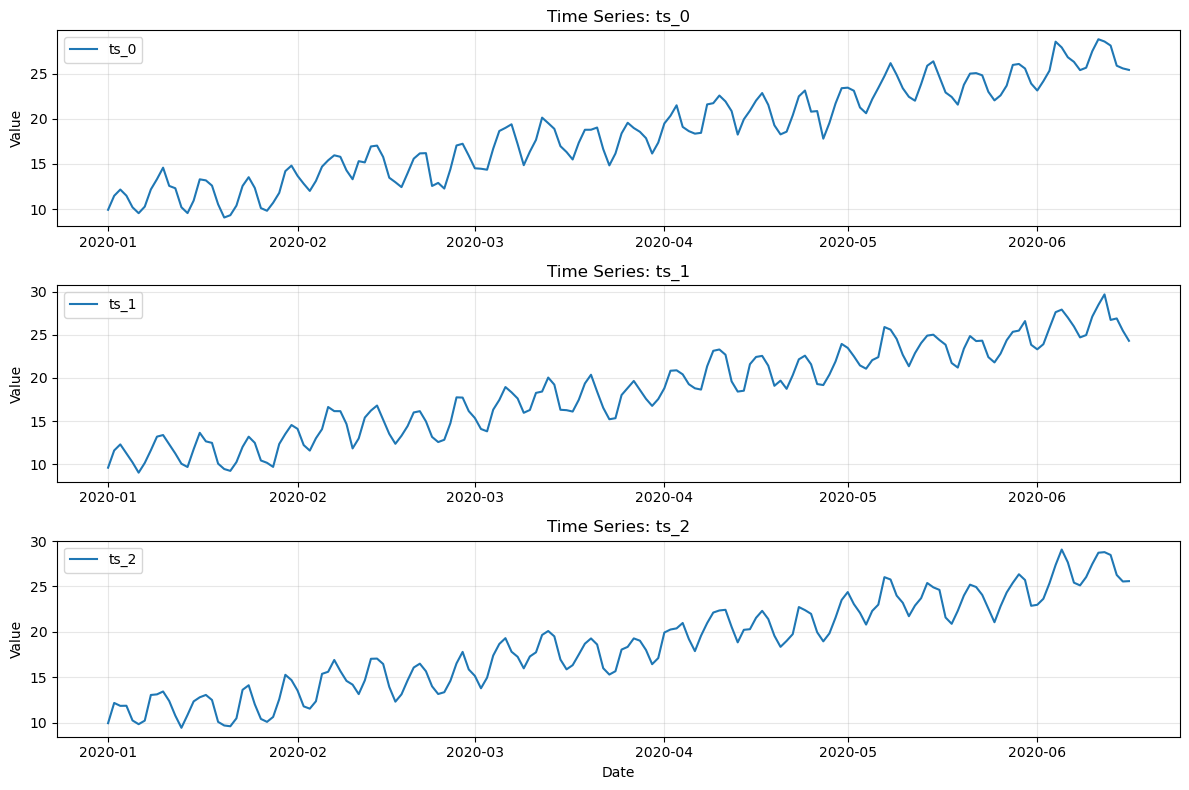

In [3]:
# Plot the synthetic time series
plt.figure(figsize=(12, 8))

for i, unique_id in enumerate(Y_df['unique_id'].unique()):
    series_data = Y_df[Y_df['unique_id'] == unique_id]
    plt.subplot(len(Y_df['unique_id'].unique()), 1, i+1)
    plt.plot(series_data['ds'], series_data['y'], label=unique_id)
    plt.title(f'Time Series: {unique_id}')
    plt.ylabel('Value')
    if i == len(Y_df['unique_id'].unique()) - 1:
        plt.xlabel('Date')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Test importing the N-BEATSx modules
# Note: Make sure your N-BEATSx files are in the same directory or in your Python path

try:
    # Import the main classes (adjust paths as needed)
    import sys
    sys.path.append('.')  # Add current directory to path
    
    from nbeats import Nbeats
    from utils.ts_dataset import TimeSeriesDataset
    from utils.ts_loader import TimeSeriesLoader
    
    print("✅ Successfully imported N-BEATSx modules!")
    
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Make sure all N-BEATSx files are in the correct location")
    print("You may need to create __init__.py files in subdirectories")

✅ Successfully imported N-BEATSx modules!


In [5]:
# Create train/test split
train_size = int(0.8 * len(Y_df['ds'].unique()))
test_size = len(Y_df['ds'].unique()) - train_size

# Create train mask (1 for train, 0 for test)
ts_train_mask = np.concatenate([
    np.ones(train_size),
    np.zeros(test_size)
])

print(f"Train size: {train_size}, Test size: {test_size}")
print(f"Train mask shape: {ts_train_mask.shape}")

try:
    # Create TimeSeriesDataset
    ts_dataset = TimeSeriesDataset(
        Y_df=Y_df,
        X_df=X_df,
        S_df=S_df,
        ts_train_mask=ts_train_mask
    )
    
    print("✅ Successfully created TimeSeriesDataset!")
    print(f"Dataset properties:")
    print(f"  - Number of series: {ts_dataset.n_series}")
    print(f"  - Max length: {ts_dataset.max_len}")
    print(f"  - Number of channels: {ts_dataset.n_channels}")
    print(f"  - Number of X features: {ts_dataset.n_x}")
    print(f"  - Number of S features: {ts_dataset.n_s}")
    
except Exception as e:
    print(f"❌ Error creating dataset: {e}")

Train size: 134, Test size: 34
Train mask shape: (168,)
Processing dataframes ...
❌ Error creating dataset: module 'numpy' has no attribute 'asscalar'
